C:\Users\uriel96\AppData\Local\Temp\ipykernel_12740\3836478165.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM diabetes", connection)
C:\Users\uriel96\AppData\Local\Temp\ipykernel_12740\3836478165.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.dropna(inplace=True)
C:\Users\uriel96\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


OLAP Cube:
                                    outcome
pregnancies glucose blood_pressure         
0           57      60                    0
            67      76                    0
            73      0                     0
            74      52                    0
            78      88                    0
...                                     ...
13          158     114                   1
14          100     78                    1
            175     62                    1
15          136     70                    1
17          163     72                    1

[754 rows x 1 columns]

Diced Cube:
                                    outcome
pregnancies glucose blood_pressure         
0           140     65                    1
1           140     74                    0
9           140     94                    1
12          140     82                    1
                    85                    0

Rolled-Up Cube:
         outcome
glucose         
0              2
44  

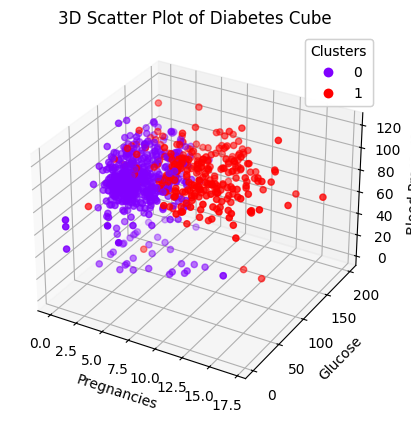

In [16]:
import pandas as pd
import numpy as np
import duckdb
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a connection to DuckDB and create a table
connection = duckdb.connect()
connection.execute('''
CREATE TABLE diabetes (
    pregnancies INTEGER,
    glucose INTEGER,
    blood_pressure INTEGER,
    skin_thickness INTEGER,
    insulin INTEGER,
    BMI FLOAT,
    diabetes_pedigree_function FLOAT,
    age INTEGER,
    outcome INTEGER
)
''')

# Import the CSV diabetes dataset into DuckDB
connection.execute("COPY diabetes FROM 'diabetes.csv' (HEADER)")

# Load data from DuckDB table into a Pandas DataFrame
df = pd.read_sql("SELECT * FROM diabetes", connection)

# Creating OLAP cubes using the pivot_table function
diabetes_cube = df.pivot_table(
    values='outcome',
    index=['pregnancies', 'glucose', 'blood_pressure'],
    aggfunc='sum',
    fill_value=0
)

# Print the OLAP cube
print("OLAP Cube:")
print(diabetes_cube)

# Step 9a: Dice the cube to only include people with diabetes and a glucose level of 140
diabetes_cube_diced = diabetes_cube.loc[(slice(None), 140, slice(None)), :]
print("\nDiced Cube:")
print(diabetes_cube_diced)

# Step 9b: Roll up the cube to the glucose dimension
diabetes_cube_rolled_up = diabetes_cube.groupby('glucose').sum()
print("\nRolled-Up Cube:")
print(diabetes_cube_rolled_up)

# Machine Learning
# Select features for clustering
features = df[['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'BMI', 'diabetes_pedigree_function', 'age']]

# Drop rows with missing values
features.dropna(inplace=True)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Train the K-Means clustering model (customize the number of clusters)
kmeans = KMeans(n_clusters=2)
kmeans.fit(features_scaled)

# Predict cluster labels
cluster_labels = kmeans.predict(features_scaled)

# Print the cluster labels
print("\nCluster Labels:")
print(cluster_labels)

# Create a 3D Scatter Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Pregnancies')
ax.set_ylabel('Glucose')
ax.set_zlabel('Blood Pressure')

# Scatter plot points colored by cluster
scatter = ax.scatter(features['pregnancies'], features['glucose'], features['blood_pressure'], c=cluster_labels, cmap='rainbow')

# Create a legend
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

# Set a title for the plot
plt.title('3D Scatter Plot of Diabetes Cube')
plt.show()
